In [1]:
from particle_propagation import Particle_Propagator,calulate_sigma_px,emmitance_propagation,single_particle
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm, norm

import matplotlib.pyplot as plt
import numpy as np


Propagator=Particle_Propagator()

In [2]:
%matplotlib inline

from pathlib import Path
from thor_scsi.factory import accelerator_from_config
from thor_scsi.pyflame import Config
import thor_scsi.lib as tslib

import numpy as np
import matplotlib.pyplot as plt

import gtpsa
import os
import time
import copy
import random

from multiprocessing import Process, Queue, Array
from queue import Empty

from scipy.stats import truncnorm, norm



prefix = Path(os.environ["HOME"])
prefix = Path("/home/al3xber")
t_dir =  prefix / "Desktop" / "Workspace"
t_file = t_dir / "BII_NLKmode_3d_start.lat"

x_, px_ = 0, 1
y_, py_ = 2, 3

emittance_start = 70e-9
nv = 6
mo = 1
default_desc = gtpsa.desc(nv, mo)


def create_nlk_interpolation(nlk_name):
    def compute_mirror_position_plate(ref_pos, mirror_pos, *, y_plane=True):
        assert y_plane
        dy = ref_pos.imag - mirror_pos.imag
        return ref_pos - 2 * dy * 1j

    # fmt: off
    ref_pos1 =  8e-3 +  7e-3j
    ref_pos2 = 17e-3 + 15e-3j
    # fmt: on
    t_current = -7e2

    # fmt: off
    t_current *= 1 - 1 * 0.14 / 2
    ref_pos1  *= 1 - 0.14
    ref_pos2  *= 1 - 0.14

    plate_position1 = 5e-3j
    mirror_pos1 = compute_mirror_position_plate(ref_pos1, plate_position1)

    inner = tslib.aircoil_filament(ref_pos1.real, ref_pos1.imag,  t_current)
    outer = tslib.aircoil_filament(ref_pos2.real, ref_pos2.imag, -t_current)
    mirror = tslib.aircoil_filament(mirror_pos1.real, mirror_pos1.imag, -t_current * 0.14)
    nlkf_intp = tslib.NonLinearKickerInterpolation([inner, outer, mirror])

    c = Config()
    c.setAny("L", 0e0)
    c.setAny("name", nlk_name)
    c.setAny("N", 1)
    nlk = tslib.FieldKick(c)
    nlk.set_field_interpolator(nlkf_intp)
    return nlk, nlkf_intp

def create_state_space_vector(*, mu_x=0e0, mu_px=0e0, mu_y=0e0, mu_py=0e0):
    ps = gtpsa.ss_vect_double(0.0)

    ps.set_zero()
    ps.x+=mu_x
    ps.px+=mu_px
    ps.x+=mu_y
    ps.py+=mu_py
    return ps


acc = accelerator_from_config(t_file)
calc_config = tslib.ConfigType()

print("non linear kicker, thor scsi lattice file", [elem.name for elem in acc if elem.name[:4] == "KDNL"])


#description of NLK

nlkfk = acc.find("KDNL1KR", 0)
nlk_name = nlkfk.name
nlk, nlkf_intp = create_nlk_interpolation(nlk_name)
nlkfk.set_field_interpolator(nlkf_intp)
nlkf_intp.set_scale(0.0)

non linear kicker, thor scsi lattice file ['KDNL1KR']


In [3]:
import tqdm

def create_interpolation_files(x_list,px_list):
    """
    create grid for interpolation
    """
    Z1  = np.zeros((len(x_list),len(px_list)))   #Z1, for new x value
    Z2  = np.zeros((len(x_list),len(px_list)))   #Z2, for new px value
    
    for i in tqdm.tqdm(range(len(x_list))):
        for j in range(len(px_list)):
            ps = create_state_space_vector(mu_x=x_list[i],mu_px=px_list[j])   #create electron
            result = acc.propagate(calc_config, ps)   #propagate 1 round
            
            #save information
            Z1[i,j] = ps.x   
            Z2[i,j] = ps.px
    
    return Z1, Z2

In [4]:
x_list = np.linspace(-45e-3,24.5e-3,1280)
px_list = np.linspace(-0.003,0.003,1280)
Z1,Z2 = create_interpolation_files(x_list,px_list)


100%|██████████| 1280/1280 [25:06<00:00,  1.18s/it]


In [8]:
np.save("ZroundX.npy", Z1)
np.save("ZroundPX.npy", Z2)

In [6]:
idx = (np.abs(Z1)>1)+(np.abs(Z2)>1)
Z1[idx] = float("nan")
Z2[idx] = float("nan")

<ipython-input-7-f56fa52d76e9>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Y,Z1.T)


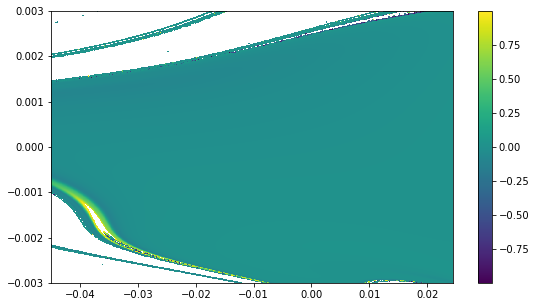

In [7]:
X,Y = np.meshgrid(x_list,px_list)
plt.figure(figsize=(9,5))
plt.pcolormesh(X,Y,Z1.T)
plt.colorbar()

<ipython-input-130-f56fa52d76e9>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Y,Z1.T)


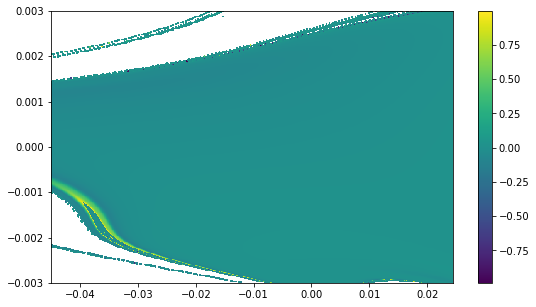

In [130]:
X,Y = np.meshgrid(x_list,px_list)
plt.figure(figsize=(9,5))
plt.pcolormesh(X,Y,Z1.T)
plt.colorbar()